# Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [2]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [3]:
import numpy as np

trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [4]:
import torch

# Assume your 'trajectories' dictionary is already loaded

# Define your target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

# 1. Define your data splits
# Pool most trajectories for training/validation during optimization.
# Hold out 1-2 trajectories that the model will NEVER see during optimization.
train_val_keys = [f'kukatraj{i}' for i in range(1, 9)]  # e.g., Trajectories 1-8
final_test_keys = ['kukatraj9', 'kukatraj10']         # e.g., Trajectories 9-10

# 2. Create the combined training/validation data pool
train_val_list = [trajectories[key] for key in train_val_keys if key in trajectories]
full_train_data = np.concatenate(train_val_list, axis=0)

# 3. Create the final, held-out test set
test_list = [trajectories[key] for key in final_test_keys if key in trajectories]
full_test_data = np.concatenate(test_list, axis=0)

# 4. Create full X and y tensors and move them to the GPU
# This is the data pool Optuna's K-Fold will use.
X_train_full = torch.from_numpy(full_train_data[:, :21]).float().to(device)
y_train_full = torch.from_numpy(full_train_data[:, 21:]).float().to(device)

# This is the data for the final performance report AFTER optimization.
X_test_final = torch.from_numpy(full_test_data[:, :21]).float().to(device)
y_test_final = torch.from_numpy(full_test_data[:, 21:]).float().to(device)

print(f"Training/Validation pool shape: {X_train_full.shape}")
print(f"Final held-out test set shape: {X_test_final.shape}")

Running on device: cuda
Training/Validation pool shape: torch.Size([16052, 21])
Final held-out test set shape: torch.Size([4016, 21])


# Optimisation
---

In [ ]:
import time
import optuna
from sklearn.model_selection import LeaveOneOut
import sys
sys.path.append('models')

import pc_esn_model

N_TRIALS = 13
optimisation_start_time = time.time()

def objective(trial):
    """
    The objective function for Optuna to optimize.
    It uses the pre-loaded GPU tensors for K-Fold Cross-Validation.
    """
    
    # 1. Suggest hyperparameters for this trial
    params = {
        'n_reservoir': trial.suggest_int('n_reservoir', 300, 3000),
        'spectral_radius': trial.suggest_float('spectral_radius', 0.5, 0.95),
        'sparsity': trial.suggest_float('sparsity', 0.6, 0.95),
        'leak_rate': trial.suggest_float('leak_rate', 0.65, 1.5),
        'ghl_eta': trial.suggest_float('ghl_eta', 1e-5, 1e-3, log=True),
        'ghl_decay_steps': trial.suggest_int('ghl_decay_steps', 1000, 10000)
    }

    # 2. Perform K-Fold Cross-Validation
    train_val_keys = [f'kukatraj{i}' for i in range(1, 6)]
    loo = LeaveOneOut()
    fold_errors = []

    #for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    for train_idx, val_idx in loo.split(range(len(train_val_keys))):

        train_trajs = [train_val_keys[i] for i in train_idx]
        val_traj = train_val_keys[val_idx[0]]
        
        # Concatenate training trajectories (assuming trajectories are torch tensors)
        X_train_list = [torch.from_numpy(trajectories[traj][:, :21]).float().to(device) for traj in train_trajs]
        y_train_list = [torch.from_numpy(trajectories[traj][:, 21:]).float().to(device) for traj in train_trajs]
        X_train = torch.cat(X_train_list, dim=0)
        y_train = torch.cat(y_train_list, dim=0)

        # Validation trajectory
        X_val = torch.from_numpy(trajectories[val_traj][:, :21]).float().to(device)
        y_val = torch.from_numpy(trajectories[val_traj][:, 21:]).float().to(device)

        # Instantiate the model with trial params, ensuring it's on the correct device
        model = pc_esn_model.PC_ESN(
            n_inputs=X_train.shape[1],
            n_outputs=y_train.shape[1],
            n_reservoir=params['n_reservoir'],
            spectral_radius=params['spectral_radius'],
            sparsity=params['sparsity'],
            leak_rate=params['leak_rate'],
            ghl_eta=params['ghl_eta'],
            ghl_decay_steps=params['ghl_decay_steps'],
            device=device  # Pass the device to the model
        )

        model.train(X_train, y_train)
        
        predictions = model.predict_full_trajectory(X_val)
        
        # Calculate nMSE
        true_values = y_val.cpu().numpy()
        error = np.mean((predictions - true_values)**2)
        variance = np.var(true_values)
        
        # Avoid division by zero if variance is tiny
        nMSE = error / (variance + 1e-9)
        fold_errors.append(nMSE)

    # Number of trials completed so far (1-based)
    trials_done = trial.number + 1
    total_trials = N_TRIALS

    # Elapsed wall‐clock seconds
    elapsed = time.time() - optimisation_start_time

    # Average time per trial
    avg_time_per_trial = elapsed / trials_done

    # Trials left
    remaining = total_trials - trials_done

    # Estimated seconds remaining
    eta_seconds = avg_time_per_trial * remaining

    # Pretty‐print in minutes:seconds
    mins, secs = divmod(int(eta_seconds), 60)
    print(
        f"Trial {trials_done}/{total_trials} done "
        f"(elapsed {elapsed:.1f}s). "
        f"ETA: {mins}m {secs}s"
    )

    # 3. Return the average error across all folds
    average_nMSE = np.mean(fold_errors)
    
    return average_nMSE

In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2025-07-15 21:54:55,068] A new study created in memory with name: no-name-d52c0b97-6a97-4e73-9860-cfc294e96aa8
[I 2025-07-15 21:58:17,003] Trial 0 finished with value: 0.2883145005140317 and parameters: {'n_reservoir': 529, 'spectral_radius': 0.6834912490850534, 'sparsity': 0.7792174232805548, 'leak_rate': 1.0922675594007965, 'ghl_eta': 1.382137250169189e-05, 'ghl_decay_steps': 9447}. Best is trial 0 with value: 0.2883145005140317.


Trial 1/13 done (elapsed 201.9s). ETA: 40m 23s


[I 2025-07-15 22:19:45,842] Trial 1 finished with value: 0.5475203536420304 and parameters: {'n_reservoir': 1818, 'spectral_radius': 0.5882380539898393, 'sparsity': 0.9152058288786025, 'leak_rate': 0.6901887684906224, 'ghl_eta': 0.0003165384618130502, 'ghl_decay_steps': 5095}. Best is trial 0 with value: 0.2883145005140317.


Trial 2/13 done (elapsed 1490.8s). ETA: 136m 39s


[I 2025-07-15 22:23:44,697] Trial 2 finished with value: 0.30136716498886923 and parameters: {'n_reservoir': 932, 'spectral_radius': 0.7154617681207625, 'sparsity': 0.6988561283614031, 'leak_rate': 1.3679527758549133, 'ghl_eta': 0.00020098851458944927, 'ghl_decay_steps': 3246}. Best is trial 0 with value: 0.2883145005140317.


Trial 3/13 done (elapsed 1729.6s). ETA: 96m 5s


[I 2025-07-15 22:38:28,613] Trial 3 finished with value: 0.8255334177964662 and parameters: {'n_reservoir': 1536, 'spectral_radius': 0.9337521559239774, 'sparsity': 0.6128502185562976, 'leak_rate': 0.804672291030079, 'ghl_eta': 0.00018223596112208277, 'ghl_decay_steps': 6160}. Best is trial 0 with value: 0.2883145005140317.


Trial 4/13 done (elapsed 2613.6s). ETA: 98m 0s


[I 2025-07-15 22:55:09,775] Trial 4 finished with value: 0.2307341429073388 and parameters: {'n_reservoir': 1791, 'spectral_radius': 0.6528993614995149, 'sparsity': 0.6983724848673941, 'leak_rate': 1.1481726877092728, 'ghl_eta': 1.078301434941451e-05, 'ghl_decay_steps': 3824}. Best is trial 4 with value: 0.2307341429073388.


Trial 5/13 done (elapsed 3614.7s). ETA: 96m 23s


[I 2025-07-16 00:06:15,267] Trial 5 finished with value: 0.3607417090889584 and parameters: {'n_reservoir': 2946, 'spectral_radius': 0.5266549152291903, 'sparsity': 0.704697661999718, 'leak_rate': 1.0427165546558992, 'ghl_eta': 1.181514988032658e-05, 'ghl_decay_steps': 7715}. Best is trial 4 with value: 0.2307341429073388.


Trial 6/13 done (elapsed 7880.2s). ETA: 153m 13s


[I 2025-07-16 00:27:35,316] Trial 6 finished with value: 0.3663204715438002 and parameters: {'n_reservoir': 1798, 'spectral_radius': 0.6920958865047308, 'sparsity': 0.8519398623873963, 'leak_rate': 1.3979100067611654, 'ghl_eta': 0.0002342829378714668, 'ghl_decay_steps': 7896}. Best is trial 4 with value: 0.2307341429073388.


Trial 7/13 done (elapsed 9160.3s). ETA: 130m 51s


[I 2025-07-16 01:24:18,452] Trial 7 finished with value: 0.4409653422433042 and parameters: {'n_reservoir': 2698, 'spectral_radius': 0.9018295698873295, 'sparsity': 0.8866441986591812, 'leak_rate': 1.2051398691505069, 'ghl_eta': 0.00023101348340154247, 'ghl_decay_steps': 8804}. Best is trial 4 with value: 0.2307341429073388.


Trial 8/13 done (elapsed 12563.4s). ETA: 130m 52s


[I 2025-07-16 02:06:21,437] Trial 8 finished with value: 0.41993256693233255 and parameters: {'n_reservoir': 2432, 'spectral_radius': 0.9451846164488794, 'sparsity': 0.8306491717268986, 'leak_rate': 1.2474199886576418, 'ghl_eta': 9.989950507592099e-05, 'ghl_decay_steps': 5527}. Best is trial 4 with value: 0.2307341429073388.


Trial 9/13 done (elapsed 15086.4s). ETA: 111m 45s


[I 2025-07-16 02:36:44,155] Trial 9 finished with value: 0.37453667234325283 and parameters: {'n_reservoir': 2257, 'spectral_radius': 0.5420761436727142, 'sparsity': 0.8511390737639009, 'leak_rate': 1.4289173968733135, 'ghl_eta': 3.0524339765633815e-05, 'ghl_decay_steps': 1687}. Best is trial 4 with value: 0.2307341429073388.


Trial 10/13 done (elapsed 16909.1s). ETA: 84m 32s


[I 2025-07-16 02:45:09,904] Trial 10 finished with value: 0.4182310261598129 and parameters: {'n_reservoir': 1339, 'spectral_radius': 0.803141907014785, 'sparsity': 0.6116657095407245, 'leak_rate': 0.9298957830487553, 'ghl_eta': 0.0008143390780152656, 'ghl_decay_steps': 1166}. Best is trial 4 with value: 0.2307341429073388.


Trial 11/13 done (elapsed 17414.9s). ETA: 52m 46s


[I 2025-07-16 02:48:36,462] Trial 11 finished with value: 0.44045203091523266 and parameters: {'n_reservoir': 373, 'spectral_radius': 0.6482815772170524, 'sparsity': 0.751195704860269, 'leak_rate': 1.0937560173432521, 'ghl_eta': 1.142289853212919e-05, 'ghl_decay_steps': 9899}. Best is trial 4 with value: 0.2307341429073388.


Trial 12/13 done (elapsed 17621.4s). ETA: 24m 28s


[I 2025-07-16 02:52:02,620] Trial 12 finished with value: 0.2940987575113021 and parameters: {'n_reservoir': 313, 'spectral_radius': 0.7780886829389659, 'sparsity': 0.7611809342676664, 'leak_rate': 1.0262362964881213, 'ghl_eta': 3.168988367019947e-05, 'ghl_decay_steps': 3604}. Best is trial 4 with value: 0.2307341429073388.


Trial 13/13 done (elapsed 17827.6s). ETA: 0m 0s


In [8]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.2307341429073388
  Params: 
    n_reservoir: 1791
    spectral_radius: 0.6528993614995149
    sparsity: 0.6983724848673941
    leak_rate: 1.1481726877092728
    ghl_eta: 1.078301434941451e-05
    ghl_decay_steps: 3824


/tmp/ipykernel_19/1799482134.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

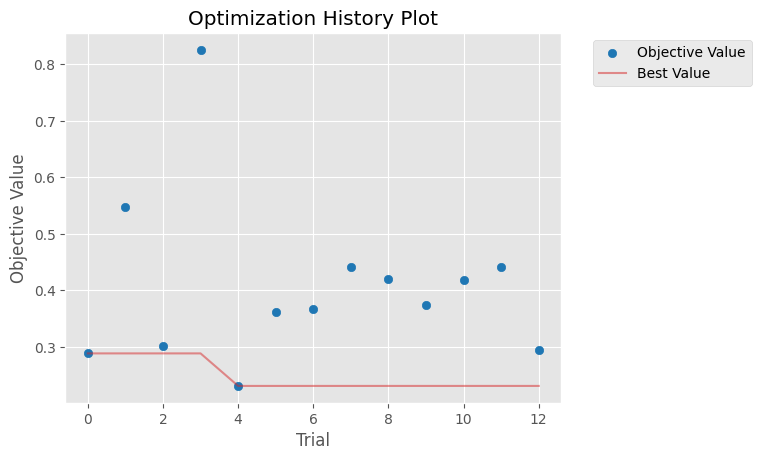

In [9]:
import optuna.visualization.matplotlib as opplt
opplt.plot_optimization_history(study)

/tmp/ipykernel_19/2166294799.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

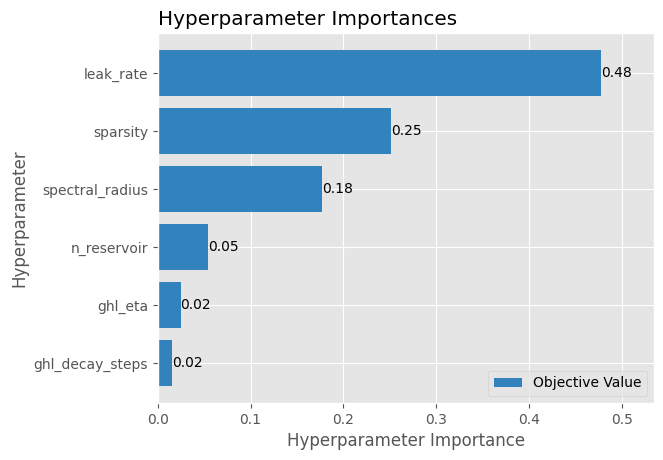

In [10]:
opplt.plot_param_importances(study)

/tmp/ipykernel_19/1148647955.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_slice(study, params=['n_reservoir', 'spectral_radius', 'sparsity', 'leak_rate', 'ghl_eta', 'ghl_decay_steps'])


array([<Axes: xlabel='ghl_decay_steps', ylabel='Objective Value'>,
       <Axes: xlabel='ghl_eta'>, <Axes: xlabel='leak_rate'>,
       <Axes: xlabel='n_reservoir'>, <Axes: xlabel='sparsity'>,
       <Axes: xlabel='spectral_radius'>], dtype=object)

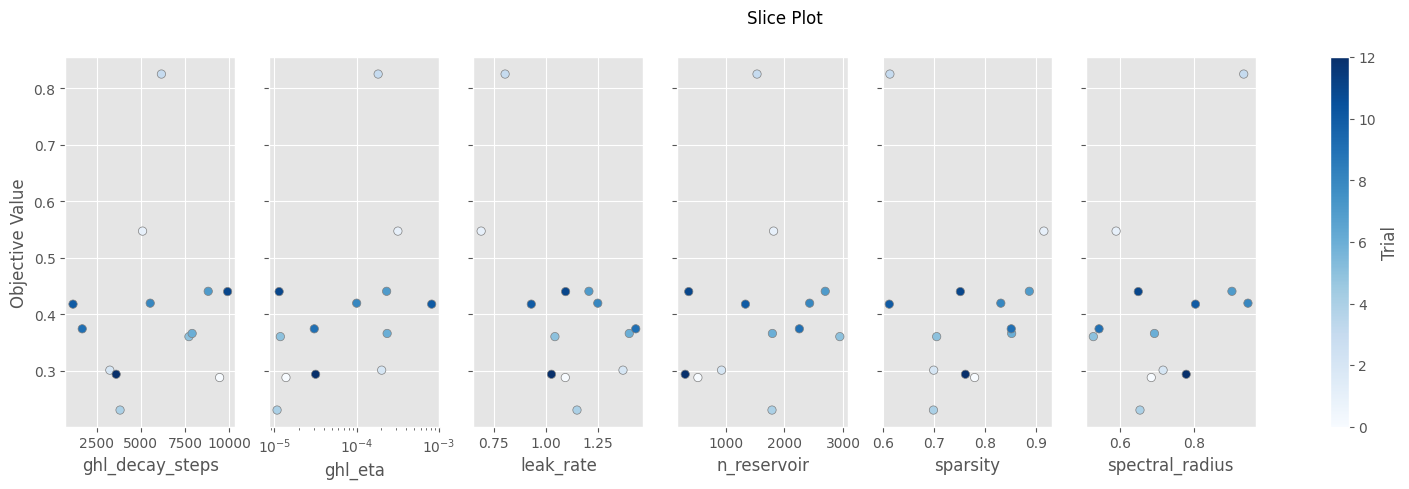

In [11]:
opplt.plot_slice(study, params=['n_reservoir', 'spectral_radius', 'sparsity', 'leak_rate', 'ghl_eta', 'ghl_decay_steps'])